# BTC

- BTC Analysis
- BTC Prediction using ML

In [1]:
# 필요한 라이브러리를 읽어오기
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Activation
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# 데이터 읽어오기
df_master = pd.read_csv(filepath_or_buffer="../data/CRIX.UPBIT.KRW-BTC_2017-09-26.csv")
df_master['date'] = pd.to_datetime(df_master['date'],unit='ms') # 날짜 변환
df_master = df_master.set_index('date'); # date 를 인덱스로 설정

In [3]:
# 데이터 훑어보기
print(df_master.info()) # basic info
print(df_master.head(3)) # print first 3 rows

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 111000 entries, 2017-09-25 20:21:00 to 2017-12-11 14:18:00
Data columns (total 6 columns):
low                111000 non-null float64
high               111000 non-null float64
open               111000 non-null float64
close              111000 non-null float64
volume             111000 non-null float64
weightedAverage    111000 non-null float64
dtypes: float64(6)
memory usage: 5.9 MB
None
                           low       high       open      close    volume  \
date                                                                        
2017-09-25 20:21:00  4316000.0  4321000.0  4316000.0  4321000.0  0.001888   
2017-09-25 20:22:00  4319000.0  4319000.0  4319000.0  4319000.0  0.000805   
2017-09-25 20:23:00  4318000.0  4318000.0  4318000.0  4318000.0  0.004647   

                     weightedAverage  
date                                  
2017-09-25 20:21:00         8151.393  
2017-09-25 20:22:00         3476.795  
2017-09-25 

In [4]:
# 1분 데이터를 15분 데이터로 변경
df =  df_master['close'].resample('15Min').ohlc()
print(df.info())
print(df.head(3))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7369 entries, 2017-09-25 20:15:00 to 2017-12-11 14:15:00
Freq: 15T
Data columns (total 4 columns):
open     7274 non-null float64
high     7274 non-null float64
low      7274 non-null float64
close    7274 non-null float64
dtypes: float64(4)
memory usage: 287.9 KB
None
                          open       high        low      close
date                                                           
2017-09-25 20:15:00  4321000.0  4321000.0  4317000.0  4321000.0
2017-09-25 20:30:00  4321000.0  4330000.0  4321000.0  4322000.0
2017-09-25 20:45:00  4320000.0  4330000.0  4317000.0  4322000.0


In [5]:
# 캔들 그래프는 메모리를 많이 먹는지 느려진다 ㅠㅠ
'''
trace = go.Ohlc(x=df.index,
                open=df.open,
                high=df.high,
                low=df.low,
                close=df.close)
py.iplot([trace])
'''

# 종가 그래프만 그려보자 
trace = go.Scatter(x=df.index, y=df.close)
py.iplot([trace])

## 학습 시켜보자

학습을 단순화 시키기 위해 종가(close) 값만 사용해서 학습 모델을 만들어보자. 

Time-series 데이터이기에 LSTM(Long short-term memory)를 사용해보자.

In [6]:
# 그래프를 보면 increasing trend 를 볼 수 있다.
# 이대로 학습 시킬 경우 학습 모델은 경험하지 못한 새로운 가격을 예측해야 한다는 어려움이 생긴다.
# 따라서 rate of change 기준으로 학습을 시켜보자

rate_of_change = df['close'].pct_change() # calculate rate of change
rate_of_change.iloc[0] = 0.0 # first element 는 비교할 대상이 없으므로 0으로 세팅
mask = np.isnan(rate_of_change)
rate_of_change[mask] = 0 # fill with zero

print(np.isnan(rate_of_change).any())
print(rate_of_change.head(3))

False
date
2017-09-25 20:15:00    0.000000
2017-09-25 20:30:00    0.000231
2017-09-25 20:45:00    0.000000
Freq: 15T, Name: close, dtype: float64


In [7]:
trace = go.Scatter(x=df.index, y=rate_of_change*100) # rate of change as percentage
py.iplot([trace])

In [8]:
# Normalize data
values = rate_of_change.values.reshape(-1, 1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(values)
scaled = scaler.transform(values)

In [9]:
# 데이터 split 하기
# 학습 데이터 0.8, 테스트 0.2
train_size = int(len(scaled) * 0.8)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size], scaled[train_size:len(scaled)]
train_idx, test_idx = df.index[0:train_size], df.index[train_size:len(scaled)]
print("트레이닝 데이터: ", len(train), "records")
print("테스트 데이터: ", len(test), "records")

트레이닝 데이터:  5895 records
테스트 데이터:  1474 records


In [10]:
# LSTM helper 
def create_dataset(dataset, look_back=5):
    x, y = [], []
    look_forward = 0
    for i in range(look_back, len(dataset) - look_forward):
        x_ = dataset[(i-look_back):i]
        # y_ = dataset[i:(i+look_forward)]
        y_ = dataset[i]
        x.append(x_)
        y.append(y_)
    return np.array(x), np.array(y)

look_back=10
train_x, train_y = create_dataset(train, look_back)
test_x, test_y = create_dataset(test, look_back)
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1)) # sample size, time step, feature
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))
train_y = np.reshape(train_y, (train_y.shape[0],))
test_y = np.reshape(test_y, (test_y.shape[0],))

In [11]:
print(train_x[0].shape)
print(train_x.shape)
print(train_y.shape)

(10, 1)
(5885, 10, 1)
(5885,)


In [12]:
# 모델 생성
# TODO: hypter-parameter 값 / 좋은 network 구성은 무엇일까?
model = Sequential()
model.add(LSTM(32, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32))  # return a single vector of dimension 32
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_x, train_y, epochs=50, batch_size=100, validation_data=(test_x, test_y), verbose=1, shuffle=False)


Train on 5885 samples, validate on 1464 samples
Epoch 1/50
5885/5885 [==============================] - 7s 1ms/step - loss: 0.1177 - val_loss: 0.0394
Epoch 2/50
5885/5885 [==============================] - 2s 422us/step - loss: 0.0208 - val_loss: 0.0389
Epoch 3/50
5885/5885 [==============================] - 2s 419us/step - loss: 0.0211 - val_loss: 0.0395
Epoch 4/50
5885/5885 [==============================] - 3s 425us/step - loss: 0.0215 - val_loss: 0.0392
Epoch 5/50
5885/5885 [==============================] - 2s 417us/step - loss: 0.0216 - val_loss: 0.0393
Epoch 6/50
5885/5885 [==============================] - 3s 434us/step - loss: 0.0219 - val_loss: 0.0409
Epoch 7/50
5885/5885 [==============================] - 3s 545us/step - loss: 0.0216 - val_loss: 0.0391
Epoch 8/50
5885/5885 [==============================] - 3s 495us/step - loss: 0.0214 - val_loss: 0.0396
Epoch 9/50
5885/5885 [==============================] - 3s 436us/step - loss: 0.0216 - val_loss: 0.0402
Epoch 10/50
5885/5

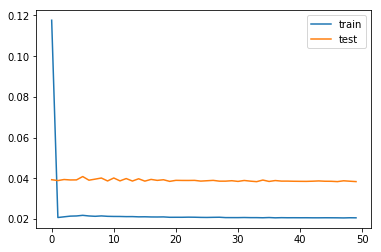

In [13]:
# Training Error 를 그려보자
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [14]:
# Prediction
pred_y = model.predict(test_x)

# Restore from min max scaler
pred_y_onestep = scaler.inverse_transform(pred_y.reshape(-1, 1))
test_y_onestep = scaler.inverse_transform(test_y.reshape(-1, 1))


In [15]:
df_test = df[train_size:len(df)]
print(len(df_test))
print(len(test))
print(len(pred_y_onestep))
print(len(test_y_onestep))

# 예측 값 복원하기 
pred_close = []
for i in range(len(pred_y_onestep)):
    j = look_back + i
    pred_close.append(df_test.iloc[j]['close'] * (1.00 + pred_y_onestep[i]))

# 테스트 데이터
df_test_pred = pd.DataFrame(df_test.iloc[-len(pred_y_onestep):])
df_test_pred["close_pred"] = np.array(pred_close)

# 그래프 그려보기
trace_real = go.Scatter(x=df_test_pred.index, y=df_test_pred["close"], name="Real") # real
trace_pred = go.Scatter(x=df_test_pred.index, y=df_test_pred["close_pred"], name="Prediction") # pred
py.iplot([trace_real, trace_pred])

1474
1474
1464
1464


In [16]:
rmse = sqrt(mean_squared_error(test_y_onestep, pred_y_onestep))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.013


Acknowledgement: 
  - https://www.kaggle.com/jphoon/bitcoin-time-series-prediction-with-lstm
  - https://stackoverflow.com/questions/43034960/many-to-one-and-many-to-many-lstm-examples-in-keras
  - https://github.com/keras-team/keras/issues/6063
  - https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/